In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [3]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, 
                                                                    test_size=0.25, random_state=1)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

2110848/2110848 [==============================] - 0s 0us/step
6736
2246
2246
46


In [4]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

In [6]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
model = models.Sequential([
    layers.Dense(128, input_shape=(10000,), name='input'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(128, name='hidden'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    layers.Dense(46, activation='softmax', name='output')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 128)               1280128   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 hidden (Dense)              (None, 128)               16512     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [8]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', 
                     verbose=1, save_best_only=True)

history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=512,
                    callbacks=[es, mc],
                    validation_data=(x_val, y_val))

Epoch 1/40


2023-07-25 17:08:48.804186: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/14 [======================>.......] - ETA: 0s - loss: 2.2947 - accuracy: 0.5160
Epoch 1: val_accuracy improved from -inf to 0.68700, saving model to best_model.h5
14/14 [==============================] - 1s 38ms/step - loss: 2.1740 - accuracy: 0.5456 - val_loss: 3.3083 - val_accuracy: 0.6870
Epoch 2/40
13/14 [==========================>...] - ETA: 0s - loss: 1.1682 - accuracy: 0.7494
Epoch 2: val_accuracy improved from 0.68700 to 0.72529, saving model to best_model.h5
14/14 [==============================] - 0s 25ms/step - loss: 1.1666 - accuracy: 0.7493 - val_loss: 3.0751 - val_accuracy: 0.7253
Epoch 3/40
13/14 [==========================>...] - ETA: 0s - loss: 0.8564 - accuracy: 0.8090
Epoch 3: val_accuracy improved from 0.72529 to 0.73553, saving model to best_model.h5
14/14 [==============================] - 0s 22ms/step - loss: 0.8537 - accuracy: 0.8095 - val_loss: 2.8328 - val_accuracy: 0.7355
Epoch 4/40
11/14 [======================>.......] - ETA: 0s - loss: 0.6617 - accurac

/var/folders/4w/mvrr1vrs1h7_1rt6w70vx4zm0000gn/T/ipykernel_5164/1201330491.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


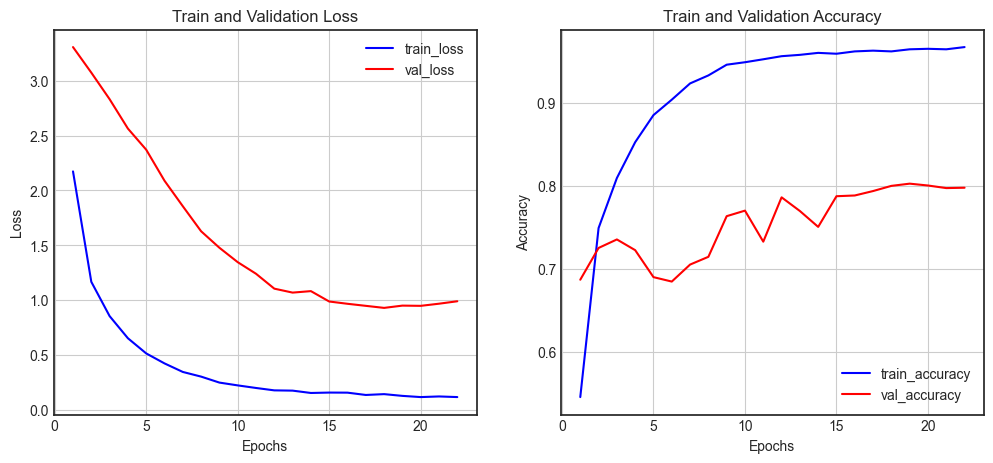

In [9]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

In [10]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
loaded_model = models.load_model('best_model.h5')
loaded_model.evaluate(x_test, y_test)[1]

71/71 [==============================] - 0s 1ms/step - loss: 0.9809 - accuracy: 0.7845


0.7845057845115662